## Tree Models

In [1]:
import time
import json
from tqdm import tqdm
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from features import feature_pipeline

In [2]:
import graphviz
import re
from sklearn.tree import export_graphviz

# From DSCI 571 Lab 1 Solutions
def display_tree(feature_names, tree, save=False, save_name="tree"):
    """ For binary classification only """
    dot = export_graphviz(
        tree,
        out_file=None,
        feature_names=feature_names,
        class_names=tree.classes_.astype(str),
        impurity=False,
    )
    # adapted from https://stackoverflow.com/questions/44821349/python-graphviz-remove-legend-on-nodes-of-decisiontreeclassifier
    dot = re.sub("(\\\\nsamples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])", "", dot)
    dot = re.sub("(samples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])\\\\n", "", dot)
    if save:
        graph = graphviz.Source(dot)
        graph.render(save_name)
    return graphviz.Source(dot)

#### Data Loading

In [3]:
with open("../data/train_features.json", "r", encoding="utf-8") as f:
    train = pd.DataFrame(json.load(f))
with open("../data/val_features.json", "r", encoding="utf-8") as f:
    val = pd.DataFrame(json.load(f))
with open("../data/test_features.json", "r", encoding="utf-8") as f:
    test = pd.DataFrame(json.load(f))

In [4]:
X_train = train.iloc[:, 1:-1]
y_train = train["level"].tolist()
X_val = val.iloc[:, 1:-1]
y_val = val["level"].tolist()
X_test = test.iloc[:, 1:-1]
y_test = test["level"].tolist()

In [5]:
print(
    f"All features:\n{list(X_train.columns)}\n\nNumber of features: {len(X_train.columns)}"
)

All features:
['total_tokens', 'total_tokens_w/o_stopwords', 'avg_sent_length', 'proportion_of_A_level_tokens', 'proportion_of_A_level_types', 'num_connectives', 'logical_operator_density', 'pronoun_density', 'type_token_ratio', 'avg_rank_of_lemmas_in_freq_list', 'fernandez_huerta_score', 'syllables_per_sentence', 'avg_degree_of_abstraction', 'min_degree_of_abstraction', 'avg_ambiguation_all_words', 'avg_ambiguation_content_words', 'noun_phrase_density', 'avg_parse_tree_depth', 'Fut', 'Imp', 'Past', 'Pres', 'ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', 'EOL', 'SPACE', 'CONTENT', 'FUNCTION']

Number of features: 44


In [6]:
print(X_train)

     total_tokens  total_tokens_w/o_stopwords  avg_sent_length  \
0            2585                        1118        35.410959   
1            1539                         622        14.941748   
2             159                          70        22.714286   
3             291                         117        22.384615   
4             401                         193        21.105263   
..            ...                         ...              ...   
252           142                          48        35.500000   
253            84                          33        28.000000   
254           153                          54        10.928571   
255           304                         143        30.400000   
256          3054                        1214        17.061453   

     proportion_of_A_level_tokens  proportion_of_A_level_types  \
0                        0.339893                     0.182550   
1                        0.326367                     0.214612   
2        

In [7]:
print(y_train)  # Training for 5 level classification

['B', 'B', 'A2', 'B', 'B', 'A2', 'A1', 'B', 'B', 'A1', 'B', 'A1', 'A1', 'A1', 'B', 'A2', 'A1', 'B', 'A1', 'A1', 'B', 'B', 'A2', 'A1', 'A2', 'A1', 'A2', 'B', 'A2', 'B', 'B', 'A2', 'B', 'A2', 'B', 'A2', 'B', 'A2', 'B', 'B', 'A1', 'B', 'B', 'A1', 'A1', 'A2', 'B', 'B', 'B', 'B', 'A2', 'A1', 'A2', 'B', 'B', 'A2', 'A1', 'A1', 'A1', 'A2', 'A1', 'B', 'B', 'B', 'B', 'A1', 'B', 'B', 'A1', 'B', 'B', 'A2', 'A1', 'B', 'B', 'B', 'B', 'B', 'A1', 'B', 'A1', 'B', 'B', 'B', 'A2', 'A2', 'B', 'A1', 'B', 'A1', 'B', 'A1', 'A2', 'A1', 'A1', 'B', 'B', 'B', 'B', 'B', 'A1', 'A1', 'A1', 'B', 'B', 'B', 'A2', 'A2', 'A2', 'B', 'A2', 'B', 'B', 'B', 'B', 'B', 'A1', 'B', 'B', 'A1', 'A1', 'B', 'B', 'B', 'A2', 'B', 'B', 'A1', 'B', 'A1', 'A1', 'B', 'B', 'A1', 'A1', 'A1', 'B', 'A1', 'B', 'A2', 'B', 'B', 'B', 'A1', 'A1', 'A2', 'B', 'B', 'A1', 'B', 'A1', 'B', 'A2', 'A1', 'A1', 'A1', 'A1', 'A2', 'A1', 'A2', 'B', 'B', 'A2', 'A1', 'B', 'B', 'B', 'B', 'B', 'A1', 'B', 'A1', 'B', 'B', 'A1', 'A2', 'A2', 'B', 'B', 'A1', 'B', 'A1', 

#### Determine the appropriate depth for the decision tree classifier

In [8]:
depths = range(1, 25)

train_accuracies = []
val_accuracies = []

for depth in depths:
    predictions = []
    tree = DecisionTreeClassifier(random_state=123, max_depth=depth)
    tree.fit(X_train, y_train)
    train_accuracies.append(tree.score(X_train, y_train))
    predicted_y_val = tree.predict(X_val, y_val)
    val_accuracies.append(accuracy_score(y_val, predicted_y_val))

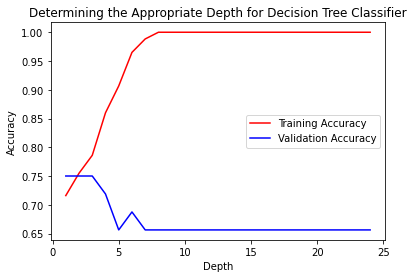

In [9]:
import matplotlib.pyplot as plt

plt.plot(depths, train_accuracies, "r")
plt.plot(depths, val_accuracies, "b")
plt.title("Determining the Appropriate Depth for Decision Tree Classifier")
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.show()

In [10]:
depth = 3
print(f"Training decision tree classifier with max depth of {depth} ...\n")
tree = DecisionTreeClassifier(random_state=123, max_depth=depth)
tree.fit(X_train, y_train)
predicted_y_train = tree.predict(X_train)
print("Training accuracy %0.3f" % (accuracy_score(y_train, predicted_y_train)))
print("\nTraining Set Classification Report:")
print(classification_report(y_train, predicted_y_train))

Training decision tree classifier with max depth of 3 ...

Training accuracy 0.786

Training Set Classification Report:
              precision    recall  f1-score   support

          A1       0.81      0.74      0.77        85
          A2       0.69      0.40      0.51        50
           B       0.79      0.98      0.87       122

    accuracy                           0.79       257
   macro avg       0.76      0.71      0.72       257
weighted avg       0.78      0.79      0.77       257



In [11]:
predicted_y_val = tree.predict(X_val)
print("Validation accuracy %0.3f" % (accuracy_score(y_val, predicted_y_val)))
print("\nValidation Set Classification Report:")
print(classification_report(y_val, predicted_y_val))

Validation accuracy 0.750

Validation Set Classification Report:
              precision    recall  f1-score   support

          A1       0.80      0.73      0.76        11
          A2       0.33      0.17      0.22         6
           B       0.79      1.00      0.88        15

    accuracy                           0.75        32
   macro avg       0.64      0.63      0.62        32
weighted avg       0.71      0.75      0.72        32



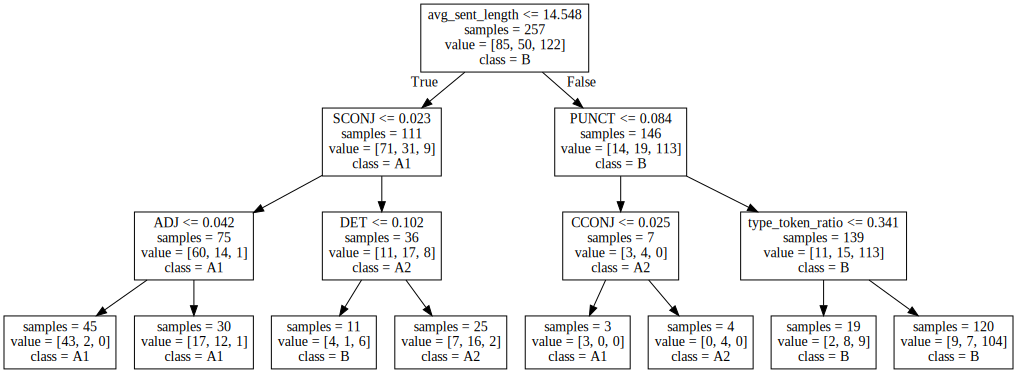

In [12]:
display_tree(X_train.columns, tree, save=True)

#### Evaluate on test data

In [13]:
predicted_y_test = tree.predict(X_test)
print("Test accuracy %0.3f" % (accuracy_score(y_test, predicted_y_test)))
print("\nTest Set Classification Report:")
print(classification_report(y_test, predicted_y_test))

Test accuracy 0.625

Test Set Classification Report:
              precision    recall  f1-score   support

          A1       0.83      0.45      0.59        11
          A2       0.50      0.33      0.40         6
           B       0.59      0.87      0.70        15

    accuracy                           0.62        32
   macro avg       0.64      0.55      0.56        32
weighted avg       0.66      0.62      0.61        32



#### Let's try some more advanced tree models too

In [14]:
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [15]:
classifiers = {
    "Random Forest": RandomForestClassifier(random_state=123),
    "XGBoost": XGBClassifier(random_state=123),
    "LightGBM": LGBMClassifier(random_state=123),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=123),
}

for (name, model) in classifiers.items():
    print(name)
    start = time.time()
    model.fit(X_train, y_train)
    print(f"Trained in {time.time() - start} seconds.")
    predicted_y_train = model.predict(X_train)
    print("Training accuracy %0.3f" % (accuracy_score(y_train, predicted_y_train)))
    print("\nTraining Set Classification Report:")
    print(classification_report(y_train, predicted_y_train))
    predicted_y_val = model.predict(X_val)
    print("Validation accuracy %0.3f" % (accuracy_score(y_val, predicted_y_val)))
    print("\nValidation Set Classification Report:")
    print(classification_report(y_val, predicted_y_val))
    predicted_y_test = model.predict(X_test)
    print("Test accuracy %0.3f" % (accuracy_score(y_test, predicted_y_test)))
    print("\nTest Set Classification Report:")
    print(classification_report(y_test, predicted_y_test))
    print()

Random Forest
Trained in 0.3552994728088379 seconds.
Training accuracy 1.000

Training Set Classification Report:
              precision    recall  f1-score   support

          A1       1.00      1.00      1.00        85
          A2       1.00      1.00      1.00        50
           B       1.00      1.00      1.00       122

    accuracy                           1.00       257
   macro avg       1.00      1.00      1.00       257
weighted avg       1.00      1.00      1.00       257

Validation accuracy 0.750

Validation Set Classification Report:
              precision    recall  f1-score   support

          A1       0.89      0.73      0.80        11
          A2       0.50      0.33      0.40         6
           B       0.74      0.93      0.82        15

    accuracy                           0.75        32
   macro avg       0.71      0.66      0.67        32
weighted avg       0.74      0.75      0.74        32

Test accuracy 0.719

Test Set Classification Report:
      

C:\Users\rsss9\miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:11:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Trained in 1.0229780673980713 seconds.
Training accuracy 1.000

Training Set Classification Report:
              precision    recall  f1-score   support

          A1       1.00      1.00      1.00        85
          A2       1.00      1.00      1.00        50
           B       1.00      1.00      1.00       122

    accuracy                           1.00       257
   macro avg       1.00      1.00      1.00       257
weighted avg       1.00      1.00      1.00       257

Validation accuracy 0.625

Validation Set Classification Report:
              precision    recall  f1-score   support

          A1       0.86      0.55      0.67        11
          A2       0.25      0.33 

#### The above was all using 3 levels of classification. Now let's try just A-B distinction.

In [16]:
y_train = []
for lvl in train["level"].tolist():
    y_train.append(lvl[0])
y_val = []
for lvl in val["level"].tolist():
    y_val.append(lvl[0])
y_test = []
for lvl in test["level"].tolist():
    y_test.append(lvl[0])

In [17]:
print(
    f"All features:\n{list(X_train.columns)}\n\nNumber of features: {len(X_train.columns)}"
)

All features:
['total_tokens', 'total_tokens_w/o_stopwords', 'avg_sent_length', 'proportion_of_A_level_tokens', 'proportion_of_A_level_types', 'num_connectives', 'logical_operator_density', 'pronoun_density', 'type_token_ratio', 'avg_rank_of_lemmas_in_freq_list', 'fernandez_huerta_score', 'syllables_per_sentence', 'avg_degree_of_abstraction', 'min_degree_of_abstraction', 'avg_ambiguation_all_words', 'avg_ambiguation_content_words', 'noun_phrase_density', 'avg_parse_tree_depth', 'Fut', 'Imp', 'Past', 'Pres', 'ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', 'EOL', 'SPACE', 'CONTENT', 'FUNCTION']

Number of features: 44


In [18]:
print(X_train)

     total_tokens  total_tokens_w/o_stopwords  avg_sent_length  \
0            2585                        1118        35.410959   
1            1539                         622        14.941748   
2             159                          70        22.714286   
3             291                         117        22.384615   
4             401                         193        21.105263   
..            ...                         ...              ...   
252           142                          48        35.500000   
253            84                          33        28.000000   
254           153                          54        10.928571   
255           304                         143        30.400000   
256          3054                        1214        17.061453   

     proportion_of_A_level_tokens  proportion_of_A_level_types  \
0                        0.339893                     0.182550   
1                        0.326367                     0.214612   
2        

In [19]:
print(y_train)  # Training for A-B classification

['B', 'B', 'A', 'B', 'B', 'A', 'A', 'B', 'B', 'A', 'B', 'A', 'A', 'A', 'B', 'A', 'A', 'B', 'A', 'A', 'B', 'B', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'B', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'B', 'A', 'B', 'B', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'A', 'A', 'A', 'B', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'A', 'B', 'B', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'A', 'B', 'B', 'B', 'A', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'A', 'A', 'A', 'B', 'B', 'B', 'A', 'A', 'A', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'A', 'A', 'B', 'B', 'B', 'A', 'B', 'B', 'A', 'B', 'A', 'A', 'B', 'B', 'A', 'A', 'A', 'B', 'A', 'B', 'A', 'B', 'B', 'B', 'A', 'A', 'A', 'B', 'B', 'A', 'B', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'A', 'B', 'B', 'A', 'A', 'A', 'B', 'B', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'B', 'B', 'A', 'A', 'A', 'B', 'B', 'B', 'A', 'A', 'B',

#### Determine the appropriate depth for the decision tree classifier

In [20]:
depths = range(1, 25)

train_accuracies = []
val_accuracies = []

for depth in depths:
    predictions = []
    tree = DecisionTreeClassifier(random_state=123, max_depth=depth)
    tree.fit(X_train, y_train)
    train_accuracies.append(tree.score(X_train, y_train))
    predicted_y_val = tree.predict(X_val, y_val)
    val_accuracies.append(accuracy_score(y_val, predicted_y_val))

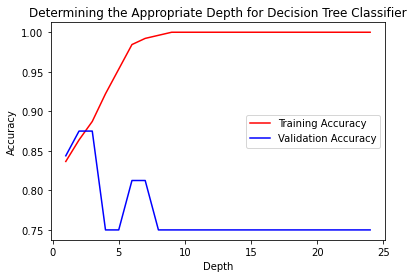

In [21]:
import matplotlib.pyplot as plt

plt.plot(depths, train_accuracies, "r")
plt.plot(depths, val_accuracies, "b")
plt.title("Determining the Appropriate Depth for Decision Tree Classifier")
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.show()

In [22]:
depth = 3
print(f"Training decision tree classifier with max depth of {depth} ...\n")
tree = DecisionTreeClassifier(random_state=123, max_depth=depth)
tree.fit(X_train, y_train)
predicted_y_train = tree.predict(X_train)
print("Training accuracy %0.3f" % (accuracy_score(y_train, predicted_y_train)))
print("\nTraining Set Classification Report:")
print(classification_report(y_train, predicted_y_train))

Training decision tree classifier with max depth of 3 ...

Training accuracy 0.887

Training Set Classification Report:
              precision    recall  f1-score   support

           A       0.97      0.81      0.88       135
           B       0.82      0.98      0.89       122

    accuracy                           0.89       257
   macro avg       0.90      0.89      0.89       257
weighted avg       0.90      0.89      0.89       257



In [23]:
predicted_y_val = tree.predict(X_val)
print("Validation accuracy %0.3f" % (accuracy_score(y_val, predicted_y_val)))
print("\nValidation Set Classification Report:")
print(classification_report(y_val, predicted_y_val))

Validation accuracy 0.875

Validation Set Classification Report:
              precision    recall  f1-score   support

           A       1.00      0.76      0.87        17
           B       0.79      1.00      0.88        15

    accuracy                           0.88        32
   macro avg       0.89      0.88      0.87        32
weighted avg       0.90      0.88      0.87        32



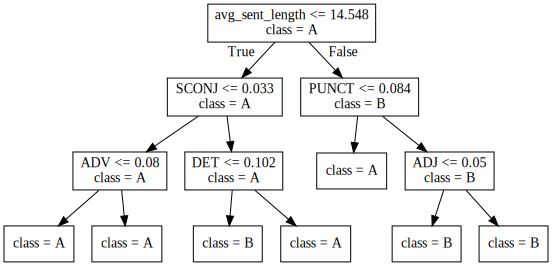

In [24]:
display_tree(X_train.columns, tree, save=True)

In [25]:
predicted_y_test = tree.predict(X_test)
print("Test accuracy %0.3f" % (accuracy_score(y_test, predicted_y_test)))
print("\nTest Set Classification Report:")
print(classification_report(y_test, predicted_y_test))

Test accuracy 0.719

Test Set Classification Report:
              precision    recall  f1-score   support

           A       0.83      0.59      0.69        17
           B       0.65      0.87      0.74        15

    accuracy                           0.72        32
   macro avg       0.74      0.73      0.72        32
weighted avg       0.75      0.72      0.71        32



#### Advanced tree models

In [26]:
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [27]:
classifiers = {
    "Random Forest": RandomForestClassifier(random_state=123),
    "XGBoost": XGBClassifier(random_state=123),
    "LightGBM": LGBMClassifier(random_state=123),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=123),
}

for (name, model) in classifiers.items():
    print(name)
    start = time.time()
    model.fit(X_train, y_train)
    print(f"Trained in {time.time() - start} seconds.")
    predicted_y_train = model.predict(X_train)
    print("Training accuracy %0.3f" % (accuracy_score(y_train, predicted_y_train)))
    print("\nTraining Set Classification Report:")
    print(classification_report(y_train, predicted_y_train))
    predicted_y_val = model.predict(X_val)
    print("Validation accuracy %0.3f" % (accuracy_score(y_val, predicted_y_val)))
    print("\nValidation Set Classification Report:")
    print(classification_report(y_val, predicted_y_val))
    predicted_y_test = model.predict(X_test)
    print("Test accuracy %0.3f" % (accuracy_score(y_test, predicted_y_test)))
    print("\nTest Set Classification Report:")
    print(classification_report(y_test, predicted_y_test))
    print()

Random Forest
Trained in 0.3725738525390625 seconds.
Training accuracy 1.000

Training Set Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       135
           B       1.00      1.00      1.00       122

    accuracy                           1.00       257
   macro avg       1.00      1.00      1.00       257
weighted avg       1.00      1.00      1.00       257

Validation accuracy 0.812

Validation Set Classification Report:
              precision    recall  f1-score   support

           A       0.87      0.76      0.81        17
           B       0.76      0.87      0.81        15

    accuracy                           0.81        32
   macro avg       0.82      0.82      0.81        32
weighted avg       0.82      0.81      0.81        32

Test accuracy 0.812

Test Set Classification Report:
              precision    recall  f1-score   support

           A       0.87      0.76      0.81        17
     

C:\Users\rsss9\miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Trained in 0.2086009979248047 seconds.
Training accuracy 1.000

Training Set Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       135
           B       1.00      1.00      1.00       122

    accuracy                           1.00       257
   macro avg       1.00      1.00      1.00       257
weighted avg       1.00      1.00      1.00       257

Validation accuracy 0.812

Validation Set Classification Report:
              precision    recall  f1-score   support

           A       0.79      0.88      0.83        17
           B       0.85      0.73      0.79        15

    accuracy                           0.81        32
   macro avg       0.82      0.81      0.81        32
weighted avg       0.82      0.81      0.81        32

Test accuracy 0.781

Test Set Classification Report:
              precision    recall  f1-score   support

           A       0.81      0.76      0.79        17
           B       